In [2]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o



Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     -------------------------------------- 177.5/177.5 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for h2o: filename=h2o-3.38.0.3-py2.py3-none-any.whl size=177541386 sha256=919964b8ec792429214881503ddfb5278080a05c8510223969abb2447b196573
  Stored in directory: c:\users\romil\appdata\local\pip\cache\wheels\42\8a\04\a258412102066310d1efaf9d7db94c3b3e6040a85da5bb3886
Successfully built h2o


In [7]:
!pip install xgboost


     ---------------------------------------- 89.1/89.1 MB 5.4 MB/s eta 0:00:00


In [4]:
import h2o
import pandas as pd
from h2o.estimators import H2OXGBoostEstimator
h2o.init(min_mem_size = "8G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.1+10-21, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\romil\AppData\Local\Temp\tmpz_v9qyy8
  JVM stdout: C:\Users\romil\AppData\Local\Temp\tmpz_v9qyy8\h2o_romil_started_from_python.out
  JVM stderr: C:\Users\romil\AppData\Local\Temp\tmpz_v9qyy8\h2o_romil_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_romil_psqu5o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [10]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


root_path ="D:\\Vaastu\\Utilities\\"

model_vf = xgb.Booster()
model_vf.load_model(root_path + "train_model_dpth_gamma_lr_80.30.1.json")
feature_important = model_vf.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
top_features   = keys[0:500]
rel_features=top_features
rel_features.append("DPD_60_plus_18")


In [11]:
base_data=pd.read_pickle(root_path + "modelbase_CV.pkl")
#driverset= pd.read_pickle('driverset_18M.pkl')

rel_columns =top_features.append("DPD_60_plus_18")
hf = h2o.H2OFrame(base_data[list(set(rel_features))])


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
def calculate_woe_iv(dataset, feature_b, target):
    
    dataset[feature_b].replace([np.inf, -np.inf], np.nan, inplace = True)
     
    if dataset[feature_b].dtype in ['float64', 'int64']:
        #dataset[dataset[feature_b]< 0][feature_b] = 0
        dataset['feature'] = pd.qcut(dataset[feature_b], q = [0, .05, .1, .2,.4, .6, .8,0.9,0.95, 1],
                                     duplicates = 'drop', precision = 0).values.add_categories(['Missing', 'Others'])
    else:
        dataset['feature'] = dataset[feature_b]

    dataset['feature'].fillna('Missing', inplace = True)
    
    #print(dataset['feature'].unique())

    lst = []
    num_rows = dataset.shape[0]

    val_list = dataset['feature'].unique()
    for val in val_list:
        occ_val = dataset[dataset['feature'] == val].count()['feature']
        if occ_val < 0.005 * num_rows :
            dataset['feature'] = np.where(dataset['feature'] == val, 'Others', dataset['feature'])

    val_list = dataset['feature'].unique()
    for val in val_list:
        lst.append({
        'Feature': feature_b,
        'Value': val,
        'Min_val': dataset[dataset['feature'] == val].min()[feature_b],
        'All': dataset[dataset['feature'] == val].count()['feature'],
        'Good': dataset[(dataset['feature'] == val) & (dataset[target] == 0)].count()['feature'],
        'Bad': dataset[(dataset['feature'] == val) & (dataset[target] == 1)].count()['feature']
        })

    dset = pd.DataFrame(lst)
    dset['Event_rate'] = dset['Bad'] / dset['All']
    dset['Prop'] = dset['All'] / dset['All'].sum()
    dset['Prop_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Prop_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Prop_Good'] / dset['Prop_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV_component'] = (dset['Prop_Good'] - dset['Prop_Bad']) * dset['WoE']

    iv = dset['IV_component'].sum()

    dset = dset.sort_values(by = 'Min_val')

    return dset, iv

In [ ]:

!pip install shutup
import shutup 
shutup.please()


In [ ]:
feat_list = base_data.columns[5:]
iv_summ=[]
for feat in feat_list:
    print(feat)
    dset, iv = calculate_woe_iv(base_data,feat , "DPD_60_plus_18")
    dset['Feature'] = feat
    iv_summ.append(iv)
    if feat == feat_list[0]:
        dset_summ= dset
    else:
        dset_summ = dset_summ.append(dset, ignore_index=True)
        
dset_summ.to_csv("Woe_table.csv")       
df_iv = pd.DataFrame(list(zip(iv_summ, feat_list)),
                 columns=['IV', 'Feature'])

df_iv.to_csv("IV_table.csv")       


In [12]:
from h2o.estimators import H2OXGBoostEstimator
hf["DPD_60_plus_18"] = hf["DPD_60_plus_18"].asfactor()
predictors = list(set(hf.columns)- set(["DPD_60_plus_18"]))
response = "DPD_60_plus_18"

# Split the dataset into a train and valid set:
train, valid = hf.split_frame(ratios=[.75], seed=1234)
train.shape, valid.shape, train[predictors].shape

((23538, 501), (7748, 501), (23538, 500))

In [15]:
from h2o.estimators import H2OGradientBoostingEstimator

# Set the predictors and response; set the response as a factor:


# Build and train the model:
pros_gbm = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=1111,
                                        keep_cross_validation_predictions = True)
pros_gbm.train(x=predictors, y=response, training_frame=train)

model_path = h2o.save_model(model=best_model, path="C:\\Users\\romil\\baseline_model", force=True)
#print model_path

# load the model
#saved_model = h2o.load_model(model_path)


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
import os
os.getcwd()
model_path = h2o.save_model(model=best_model, path="C:\\Users\\romil\\baseline_model\\final_grid_model_11", force=True)


In [30]:

model_path="C:\\Users\\romil\\baseline_model\\final_grid_model_11"

saved_model = h2o.load_model(model_path)
varimp = saved_model.varimp(use_pandas=True)
varimp.to_csv("Variable_imp.csv")

In [31]:
saved_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: final_grid_model_11


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1                  1                           539                    6            6            6             38            38            38

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.14346380912384424
RMSE: 0.3787661668151529
LogLoss: 0.4605937931051867
Mean Per-Class Error: 0.4207970263707434
AUC: 0.6256331629799778
AUCPR: 0.3270291075995922
Gini: 0.2512663259599557

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1750516188746862
       0     1      Error    Rate
-----  ----  -----  -------  -----------------
0      7314  12098  0.6232   (12098.0/19412.0)
1      901   3225   0.2184   (901.0/4126.0)
Total  8215  15323  0.5523   (12999.0/23538.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.175052     0.331637  20
max f2                       0.172051     0.516132  21
max f0point5                 0.180267     0.318124  16
max accuracy                 0.194777     0.836435  11
max precision                0.220894     1         0
max recall                   0.170378     1         23
max specificity              0.220894     1         0
max absolute_mcc             0.194777     0.232096  11
max min_per_class_accuracy   0.177532     0.385846  19
max mean_per_class_accuracy  0.177532     0.585876  19
max tns                      0.220894     19412     0
max fns                      0.220894     3997      0
max fps                      0.166613     19412     24
max tps                      0.170378     4126      23
max tnr                      0.220894     1         0
max fnr                      0.220894     0.968735  0
max fpr                      0.166613     1         24
max tpr                      0.170378     1         23

Gains/Lift Table: Avg response rate: 17.53 %, avg score: 17.54 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------  --------------------
1        0.0118957                   0.209867           5.21582   5.21582            0.914286         0.215826  0.914286                    0.215826            0.0620456       0.0620456                  421.582    421.582            0.0608092
2        0.0203926                   0.187817           3.4514    4.48064            0.605            0.198123  0.785417                    0.20845             0.0293262       0.0913718                  245.14     348.064            0.0860658
3        0.21187                     0.178087           1.32652   1.63011            0.232527         0.178202  0.285743                    0.181114            0.253999        0.345371                   32.6521    63.0106            0.161876
4        0.65099                     0.175052           0.993483  1.20068            0.174149         0.175234  0.210468                    0.177148            0.436258        0.781629                   -0.651723  20.0677            0.158406
5        0.996134                    0.172051           0.631292  1.00339            0.11066          0.172051  0.175886                    0.175382            0.

In [17]:

# Eval performance:
perf = pros_gbm.model_performance()

# Generate predictions on a test set (if necessary):


# Extract feature interactions:
feature_interactions = pros_gbm.feature_interaction()


In [49]:
pred = pros_gbm.predict(valid)
valid['Default_Prob'] = pred['p1']
pred = pros_gbm.predict(train)

train['Default_Prob'] = pred['p1']

train_pd= h2o.as_list(train[['Default_Prob','DPD_60_plus_18']])
val_pd= h2o.as_list(valid[['Default_Prob','DPD_60_plus_18']])


train_pd['decile'] = pd.qcut(train_pd['Default_Prob'].rank(method='first'), 20, labels=np.arange(20, 0, -1))
val_pd['decile'] = pd.qcut(val_pd['Default_Prob'].rank(method='first'), 20, labels=np.arange(20, 0, -1))


df = train_pd.groupby('decile').agg({ 'Default_Prob' : [min,max,'count'],'DPD_60_plus_18' : sum }   ).reset_index()
df.columns = ['Decile' , 'From','To','Obs_train','Bads_train' ]
df['Bad_rate_train'] = df['Bads_train']/df['Obs_train']
df['Goods_train'] = df['Obs_train'] - df['Bads_train']
df['Good_Rate_train'] = df['Goods_train']/df['Obs_train']
df['Cum_Approval_rate_train'] = (df.Obs_train.cumsum() / df.Obs_train.sum()) * 100
df['Cum_Bads_train'] = df.Bads_train.cumsum() 
df['Cum_Approvals_train'] = df.Obs_train.cumsum() 
df['Cum_BadRate_train'] = df['Cum_Bads_train'] / df['Cum_Approvals_train']




df_v = val_pd.groupby('decile').agg({ 'Default_Prob' : ['count'],'DPD_60_plus_18' : sum }   ).reset_index()
df_v.columns = ['Decile' , 'Obs_val','Bads_val' ]
df_v['Bad_rate_val'] = df_v['Bads_val']/df_v['Obs_val']
df_v['Goods_val'] = df_v['Obs_val'] - df_v['Bads_val']
df_v['Good_Rate_val'] = df_v['Goods_val']/df_v['Obs_val']
df_v['Cum_Approval_rate_val'] = (df_v.Obs_val.cumsum() / df_v.Obs_val.sum()) * 100
df_v['Cum_Bads_val'] = df_v.Bads_val.cumsum() 
df_v['Cum_Approvals_val'] = df_v.Obs_val.cumsum() 
df_v['Cum_BadRate_val'] = df_v['Cum_Bads_val'] / df_v['Cum_Approvals_val']




df_comb=df.merge(df_v , on = "Decile", how ="left")
df_comb = df_comb.sort_values(by=['Decile'])
df_comb.to_csv("Benchmark_model_stats.csv")
df_comb

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,Decile,From,To,Obs_train,Bads_train,Bad_rate_train,Goods_train,Good_Rate_train,Cum_Approval_rate_train,Cum_Bads_train,...,Cum_BadRate_train,Obs_val,Bads_val,Bad_rate_val,Goods_val,Good_Rate_val,Cum_Approval_rate_val,Cum_Bads_val,Cum_Approvals_val,Cum_BadRate_val
0,20,0.076548,0.111540,1177,25,0.021240,1152,0.978760,5.000425,25,...,0.021240,388,7,0.018041,381,0.981959,5.007744,7,388,0.018041
1,19,0.111540,0.117662,1177,34,0.028887,1143,0.971113,10.000850,59,...,0.025064,387,26,0.067183,361,0.932817,10.002581,33,775,0.042581
2,18,0.117662,0.123618,1177,62,0.052676,1115,0.947324,15.001275,121,...,0.034268,388,20,0.051546,368,0.948454,15.010325,53,1163,0.045572
3,17,0.123618,0.127510,1177,101,0.085811,1076,0.914189,20.001699,222,...,0.047154,387,41,0.105943,346,0.894057,20.005163,94,1550,0.060645
4,16,0.127510,0.132589,1177,103,0.087511,1074,0.912489,25.002124,325,...,0.055225,387,47,0.121447,340,0.878553,25.000000,141,1937,0.072793
5,15,0.132589,0.138420,1177,112,0.095157,1065,0.904843,30.002549,437,...,0.061880,388,34,0.087629,354,0.912371,30.007744,175,2325,0.075269
6,14,0.138431,0.144551,1176,111,0.094388,1065,0.905612,34.998725,548,...,0.066521,387,34,0.087855,353,0.912145,35.002581,209,2712,0.077065
7,13,0.144551,0.149373,1177,107,0.090909,1070,0.909091,39.999150,655,...,0.069570,387,32,0.082687,355,0.917313,39.997419,241,3099,0.077767
8,12,0.149373,0.152061,1177,141,0.119796,1036,0.880204,44.999575,796,...,0.075151,388,58,0.149485,330,0.850515,45.005163,299,3487,0.085747
9,11,0.152061,0.155590,1177,150,0.127443,1027,0.872557,50.000000,946,...,0.080381,387,59,0.152455,328,0.847545,50.000000,358,3874,0.092411


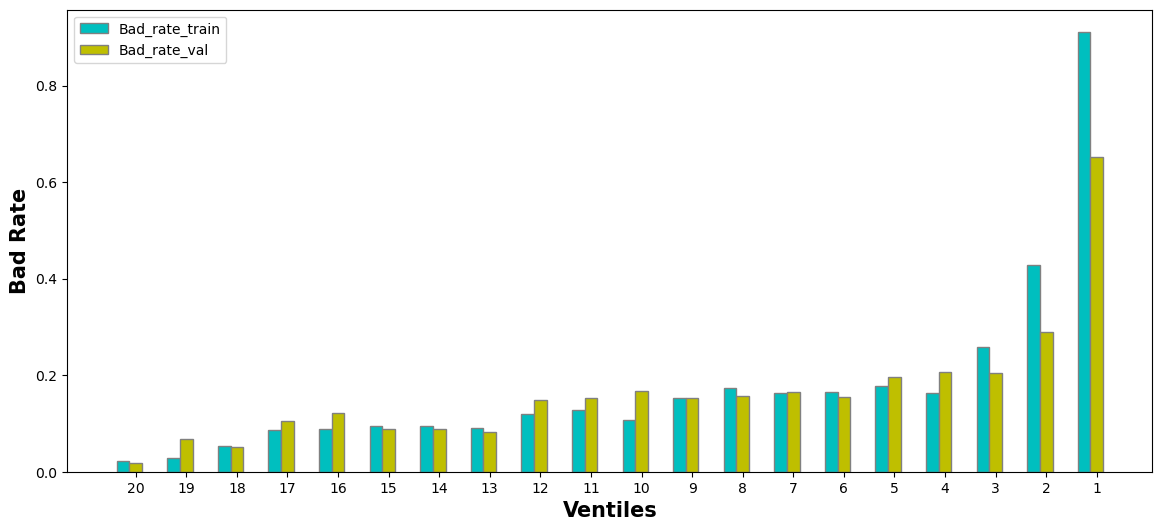

In [47]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(14, 6))
 
# set height of bar
bd_tr = df_comb['Bad_rate_train']
bd_vl = df_comb['Bad_rate_val']
 
# Set position of bar on X axis
br1 = np.arange(len(bd_tr))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, bd_tr, color ='c', width = barWidth,
        edgecolor ='grey', label ='Bad_rate_train')
plt.bar(br2, bd_vl, color ='y', width = barWidth,
        edgecolor ='grey', label ='Bad_rate_val')
 
# Adding Xticks
plt.xlabel('Ventiles', fontweight ='bold', fontsize = 15)
plt.ylabel('Bad Rate', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(bd_tr))],
        df_comb['Decile'])
 
plt.legend()
plt.show()

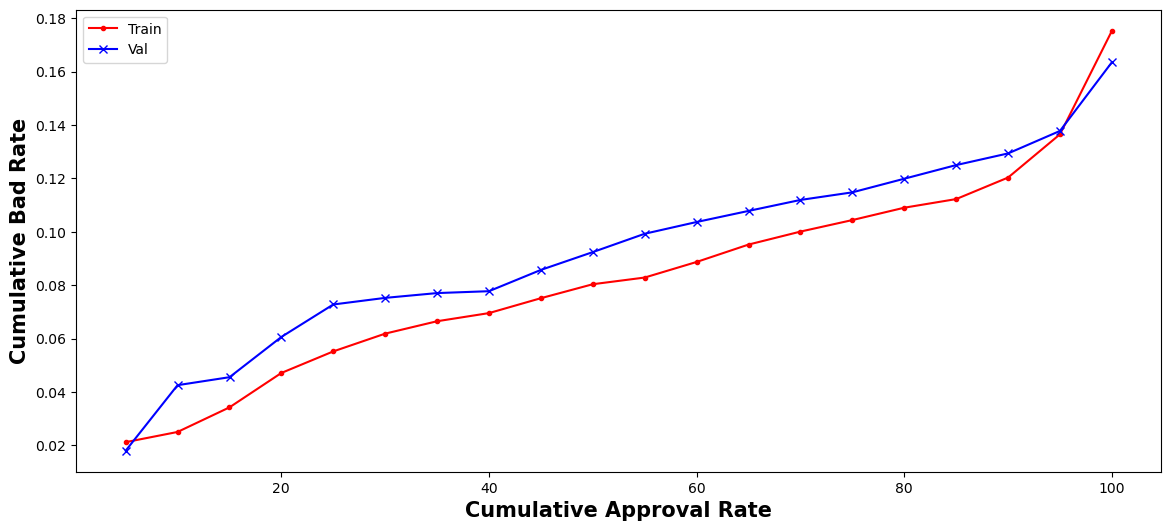

In [48]:
import matplotlib.pyplot as plt
fig = plt.subplots(figsize =(14, 6))

plt.plot(df_comb['Cum_Approval_rate_train'], df_comb['Cum_BadRate_train'], '.r-' , label= "Train") 
plt.plot(df_comb['Cum_Approval_rate_val'], df_comb['Cum_BadRate_val'], 'xb-', label= "Val") 

# Adding Xticks
plt.xlabel('Cumulative Approval Rate', fontweight ='bold', fontsize = 15)
plt.ylabel('Cumulative Bad Rate', fontweight ='bold', fontsize = 15)

 
plt.legend()
plt.show()

In [5]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(6,10,1)),
                #'sample_rate': [x/100. for x in range(20,101)],
                #'col_sample_rate' : [x/100. for x in range(20,101)],
                #'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                #'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                #'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(7,12)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

In [8]:
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch


gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ## more trees is better if the learning rate is small enough 
                    ## here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    ## smaller learning rate is better
                    ## since we have learning_rate_annealing, we can afford to start with a 
                    #bigger learning rate
                    learn_rate=0.05,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
                    ## (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    ## score every 10 trees to make early stopping reproducible 
                    #(it depends on the scoring interval)
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = 1234,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    #5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=predictors, 
           y=response,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600, 
           training_frame = train,
           validation_frame = valid)

print(final_grid)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by increasing logloss
    histogram_type    max_depth    min_split_improvement    nbins    nbins_cats    model_ids            logloss
--  ----------------  -----------  -----------------------  -------  ------------  -------------------  ---------
    QuantilesGlobal   9            1e-06                    64       1024          final_grid_model_10  0.369634
    UniformAdaptive   9            1e-08                    128      512           final_grid_model_4   0.372333
    UniformAdaptive   9            1e-08                    128      128           final_grid_model_7   0.372333
    QuantilesGlobal   8            1e-06                    512      1024          final_grid_model_8   0.378519
    UniformAdaptive   7            0                        128      128           final_grid_model_9   0.386344
    RoundRobin        7            0.0001           

In [23]:
sorted_final_grid = final_grid.get_grid(sort_by='logloss',decreasing=True)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(valid)
print(performance_best_model.logloss())
import os
os.getcwd()
model_path = h2o.save_model(model=best_model, path="C:\\Users\\romil\\best_model", force=True)
#print(sorted_final_grid)

0.4436258589422667


In [21]:
params_list = []
for key, value in best_model.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))


In [12]:
# save the model


#print model_path

# load the model
#saved_model = h2o.load_model(model_path)


In [14]:
pred = best_model.predict(valid)
valid['Default_Prob'] = pred['p1']
pred = best_model.predict(train)
train['Default_Prob'] = pred['p1']

train_pd= h2o.as_list(train[['Default_Prob','DPD_60_plus_18']])
val_pd= h2o.as_list(valid[['Default_Prob','DPD_60_plus_18']])

train_pd['decile'] = pd.qcut(train_pd['Default_Prob'].rank(method='first'), 10, labels=np.arange(10, 0, -1))
val_pd['decile'] = pd.qcut(val_pd['Default_Prob'].rank(method='first'), 10, labels=np.arange(10, 0, -1))


df = train_pd.groupby('decile').agg({ 'Default_Prob' : [min,max,'count'],'DPD_60_plus_18' : sum }   ).reset_index()
df.columns = ['Decile' , 'From','To','Obs','Bads' ]
df['Bad_rate_train'] = df['Bads']/df['Obs']

df_v = val_pd.groupby('decile').agg({ 'Default_Prob' : [min,max,'count'],'DPD_60_plus_18' : sum }   ).reset_index()
df_v.columns = ['Decile' , 'From','To','Obs','Bads' ]
df_v['Bad_rate_val'] = df_v['Bads']/df_v['Obs']

df_comb=df.merge(df_v[['Bad_rate_val','Decile']] , on = "Decile", how ="left")
df_comb = df_comb.sort_values(by=['Decile'])
df_comb

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,Decile,From,To,Obs,Bads,Bad_rate_train,Bad_rate_val
0,10,0.166613,0.172051,2354,261,0.110875,0.138065
1,9,0.172051,0.172051,2354,268,0.113849,0.101935
2,8,0.172051,0.172051,2354,246,0.104503,0.105806
3,7,0.172051,0.175052,2353,311,0.132172,0.125323
4,6,0.175052,0.175052,2354,381,0.161852,0.163871
5,5,0.175052,0.175052,2354,426,0.180969,0.190968
6,4,0.175052,0.175052,2353,349,0.148321,0.118863
7,3,0.175052,0.178087,2354,537,0.228122,0.212903
8,2,0.178087,0.178087,2354,550,0.233645,0.216774
9,1,0.178087,0.220894,2354,797,0.338573,0.260645


In [42]:
cutoff_r = [1,31,51,71,91,111,131,151,171,191,201,221,241,261,281]
def prec_recall(dataset,prob,target,event_val,cutoff_r):
    precision = []
    recall = []
    trans_delayed = []
    
  
    tp = []
    fp = []
    tn = []
    fn = []
    for ct in cutoff_r :
        cutoff = ct/1000
        TP= len(dataset[ (dataset[target] == event_val) & (dataset[prob] > cutoff) ])
       
        TN= len(dataset[ (dataset[target] != event_val ) & (dataset[prob] <= cutoff) ])
        FP= len(dataset[(dataset[target] != event_val ) & (dataset[prob] > cutoff) ])
        FN = len(dataset[(dataset[target] == event_val) &  (dataset[prob] <= cutoff)])
       
 
       
        print(ct, TP)
        Prec = -99.9999
        Rec = -99.9999
        cards_above = -99
        cards_below = -99
        if (TP + FP) >0 and TP/(TP + FN) >0:
            Prec = TP/(TP + FP)
            Rec = TP/(TP + FN)
            transactions_delayed = TP + FP
            
            
        
        trans_delayed.append(transactions_delayed)
        precision.append(Prec)
        recall.append(Rec)
        
        tp.append(TP)
        fp.append(FP)
        tn.append(TN)
        fn.append(FN)
    cutoff_metrics = pd.DataFrame(
    {'Cutoff': cutoff_r,
     'TP' : tp,
     'TN' : fp,
     'FP' : fp,
     'FN' : fn,
     'Precision': precision,
     'Recall': recall,
     'Loans_approved' : trans_delayed,
    
         
    })
    cutoff_metrics['per_trans_delayed'] = cutoff_metrics['trans_delayed']/ dataset.shape[0]
    cutoff_metrics['per_amt_delayed'] = cutoff_metrics['amt_delayed']/ dataset['cc_trans_amt_usd'].sum()
 
 
    cutoff_metrics['annual_savings_M'] = cutoff_metrics['Recall_amt']* 12
    return cutoff_metrics


met_t= prec_recall(train,"Default_Prob","DPD_60_plus_18","1",cutoff_r)

1 4126
31 4126
51 4126
71 4126
91 4126
111 4104
131 3845
151 3435
171 2347
191 1994
201 1876
221 1670
241 1500
261 1366
281 1260


KeyError: 'trans_delayed'

In [ ]:

met_v= prec_recall(train,"Default_Prob","DPD_60_plus_18","1",cutoff_r)

In [ ]:
met_t